# Single physics tutorial
Note: A lot in this tutorial requires some basic knowledge of the classes that help build up a model, thus this should be available for the users prior to tackling using them.

In this tutorial we visit how to run single physics simulations in PorePy. 
The problem in question is that of single phase flow and we will first cover incompressible flow. 
Specifically this includes topics as modifying boundary conditions, source terms and the domain, before we move on to solving the problem of slightly compressible flow.


## Running a simulation
There already exists a model for the single phase flow problem which can be accessed in PorePy, and this makes running simulations possible with only a few lines of code.
The model can be run by using the SinglePhaseFlow model class within the fluid_mass_balance.py file.

To understand the steps of the simulation, we should understand that we will run the simulation by using the PorePy method ``run_time_dependent_model``. 
This method calls the ``Model`` methods ``prepare_simulation`` and ``after_simulation``.
A user interested in the inner workings of the model is advised to inspect these methods and possibly the submethods called therein. 

Note that the method ``run_time_dependent_model`` in the first case we will look at, the incompressible flow, is only run with one time step as this is the default time step amount.
Simulations with multiple time steps, which will be visited in more detail towards the end of the tutorial, requires users to explicitly define parameters such as time step size and the times they are interested in for the simulation.

In this tutorial, we proceed to give a more pragmatic introduction on how to use and adjust a model.
Thus, we will make use of ``run_time_dependent_model`` without any further inspections of it.

## Modifying the default models
We start off by importing the necessary packages:

In [189]:
import porepy as pp
import numpy as np

## Incompressible flow
### Geometry
The necessary geometry related methods and information for a simulation is already present in the model, but as this geometry is only a unitary domain without any fractures we will look at how to change it.
In order to modify it we need to overwrite certain methods that are found in ``pp.ModelGeometry``, which is where the geometry related methods and information are found.

So, for obtaining a more interesting model geometry we define a mixin which takes care of setting a diagonal fracture into our domain:

In [190]:
class Geometry:
    def set_md_grid(self):
        # Define the domain
        self.domain = pp.Domain({"xmin": 0, "xmax": 1, "ymin": 0, "ymax": 1})

        # Generate a fracture network
        frac_1 = pp.LineFracture(np.array([[0.2, 0.8], [0.2, 0.8]]))
        fractures = [frac_1]
        fracture_network = pp.create_fracture_network(fractures, self.domain)

        # Generate the mixed-dimensional grid
        meshing_args = {"cell_size": 0.075}
        self.mdg = pp.create_mdg("simplex", meshing_args, fracture_network)

To make a new model with the modified geometry, we simply combine ``Geometry`` with the standard model using multiple inheritance

In [191]:
class SinglePhaseFlowGeometry(
    Geometry,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

In order to run the simulation we make a call to ``run_time_dependent_model``, before we make a call to ``plot_grid`` to visualize the solution

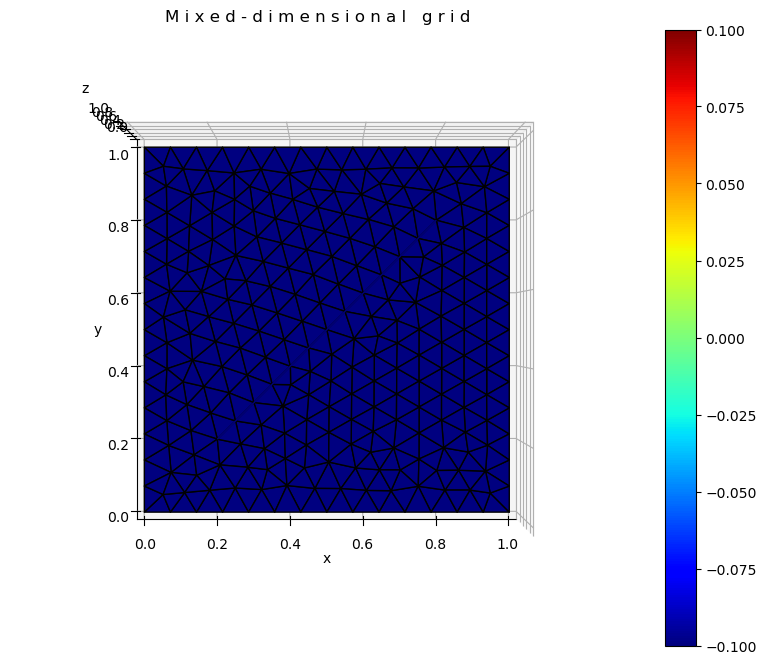

In [192]:
params = {}
model = SinglePhaseFlowGeometry(params)  
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8))

The empty `params` implies that unitary/zero default values are used for all constants.
Similarly, the default source term and boundary conditions are zero, resulting in absence of driving forces.
This provides us with the constant solution shown in the figure above.

### Boundary conditions, fluid and solid constants
One example of how to include some driving forces is by defining some non-zero boundary conditions.
This is done similarly to how we modified the geometry, meaning that we will now define a mixin for the boundary conditions.
Methods for the boundary conditions are already present in the default model class, so modifying them can be done by overwriting the methods ``bc_type`` and ``bc_values_darcy``.

In [193]:
class IncompressibleFlowBC:
    def bc_type(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        """Assign dirichlet to the west boundaries. The rest are Neumann by default."""
        _, _, west, _, _, _, _ = self.domain_boundary_sides(sd)
        bc = pp.BoundaryConditionVectorial(sd, west, "dir")
        bc.internal_to_dirichlet(sd)
        return bc

    def bc_values_darcy(self, subdomains: list[pp.Grid]):
        """Zero bc value on top and bottom, 10 on west side, 5 on east side."""
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, east, west, _, _, _, _ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(10, "Pa")
            val_loc[east] = self.fluid.convert_units(5, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

To combine the standard model with the new geometry _and_ the boundary conditions, we simply create a new class which inherits from all of them:

In [194]:
class SinglePhaseFlowGeometryBC(
    Geometry,
    IncompressibleFlowBC,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

Before we go ahead and run the model, we will also have a look at how to change parameters present in the model.
All constants in the model are either zero or unitary, and changing them is done by instantiating the fluid and solid constant classes as shown below.

In [195]:
fluid_constants = pp.FluidConstants({"viscosity": 0.1, "density": 0.2})
solid_constants = pp.SolidConstants({"permeability": 0.5, "porosity": 0.25})
material_constants = {"fluid": fluid_constants, "solid": solid_constants}
params = {"material_constants": material_constants}


Once the fluid and solid constants are defined, we collect them in the ``params`` dictionary, feed them to the model, and then run the simulation

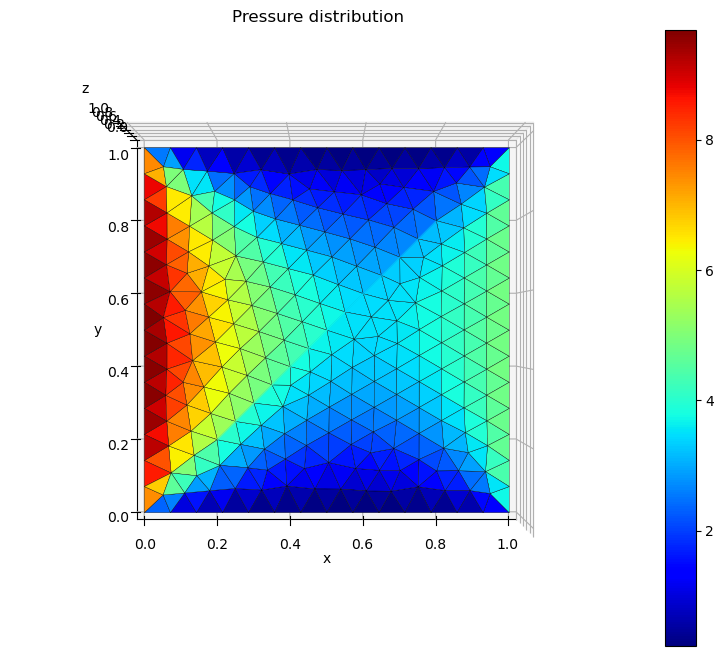

In [196]:
model = SinglePhaseFlowGeometryBC(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.25, title="Pressure distribution")

### Fracture source
Another way to modify the model is to include a fracture source.
Below we demonstrate how a unitary fracture source can be included.

In [197]:
class ModifiedSource:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign unitary fracture source"""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells))
        external_sources = pp.wrap_as_ad_array(np.hstack(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

For the sake of seeing the effects of the unitary fracture source, we do not include the non-zero boundary conditions.
This is simply done by not inheriting from ``IncompressibleFlowBC`` when creating the new model with a fracture source.

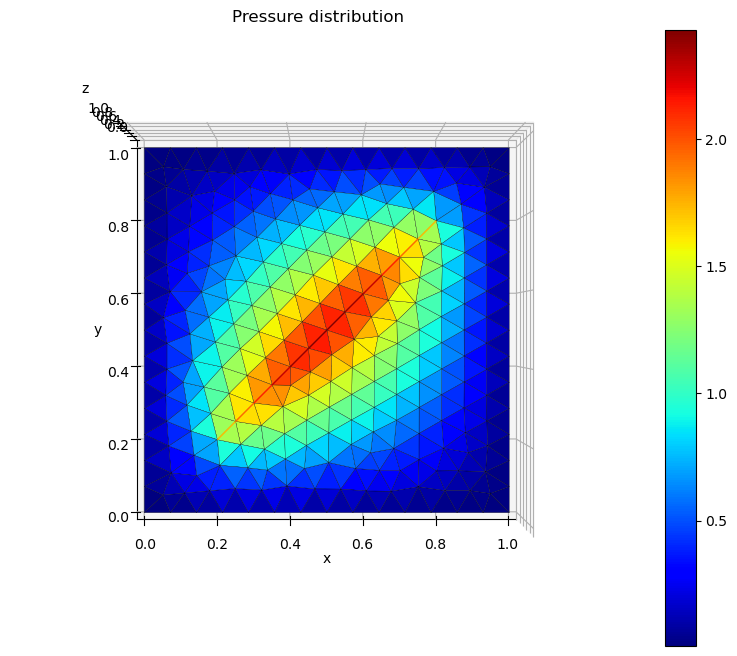

In [198]:
class SinglePhaseFlowTutorial(
    Geometry,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

model = SinglePhaseFlowTutorial(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")

## Slightly compressible flow
Building upon the model with a unitary fracture source and zero boundary conditions, we will now consider a slightly compressible fluid.
Setting the compressibility and then defining the time dependent values to put into ``params`` is the only thing needed.
The rest is just the same as before

In [199]:
class SlightlyCompressibleFlow(
    Geometry,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow
):
    ...

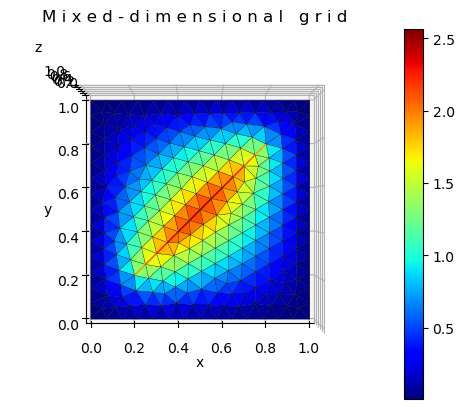

In [200]:
fluid_constants = pp.FluidConstants({"compressibility": 0.01})
material_constants = {"fluid": fluid_constants}
time_manager = pp.TimeManager(
    schedule=[0, 1e-3],
    dt_init=1e-4,
    constant_dt=True,
    iter_max=10,
    print_info=True,
)

params = {"material_constants": material_constants, "time_manager": time_manager}
model = SlightlyCompressibleFlow(params)

pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", linewidth=0.2)

The gradual evolvement of the solution can be visualized using e.g. paraview. 
Unless specified otherwise, the files contianing the time step solutions are saved in a folder with the name visualization in the working directory.